# Trading Analysis: Microsoft Stock Return Prediction

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, weekly return of the
Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model. 

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX

These datasets are extracted from Yahoo Finance and the FRED database at the St Louis Fed. In addition to predicting the stock price, we will also go through all the steps of creating a stock price prediction model. We will use closing prices from 2010 on.


<a id='1'></a>
# 2. Getting Started

In [1]:
!pip install pandas_datareader
!pip install yfinance

In [2]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Cross Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Model selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

Next, we extract the data required for our analysis using pandas datareader. 

The stock price data is coming from Yahoo while the stock index and currency data is coming fromn FRED.

In [4]:
import yfinance as yf
import pandas_datareader.data as web
import datetime

# 10 year period
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2022, 1, 1)

stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS','NASDAQCOM', 'DGS10', 'DTWEXBGS']

# We can use pandas_datareader or yfinance
# stk_data = yf.download(stk_tickers)

stk_data = web.DataReader(stk_tickers, 'yahoo', start = start, end = end)
ccy_data = web.DataReader(ccy_tickers, 'fred', start = start, end = end)
idx_data = web.DataReader(idx_tickers, 'fred', start = start, end = end)

In [5]:
stk_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-01-03 to 2021-12-31
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, MSFT)   2517 non-null   float64
 1   (Adj Close, IBM)    2517 non-null   float64
 2   (Adj Close, GOOGL)  2517 non-null   float64
 3   (Close, MSFT)       2517 non-null   float64
 4   (Close, IBM)        2517 non-null   float64
 5   (Close, GOOGL)      2517 non-null   float64
 6   (High, MSFT)        2517 non-null   float64
 7   (High, IBM)         2517 non-null   float64
 8   (High, GOOGL)       2517 non-null   float64
 9   (Low, MSFT)         2517 non-null   float64
 10  (Low, IBM)          2517 non-null   float64
 11  (Low, GOOGL)        2517 non-null   float64
 12  (Open, MSFT)        2517 non-null   float64
 13  (Open, IBM)         2517 non-null   float64
 14  (Open, GOOGL)       2517 non-null   float64
 15  (Volume, MSFT)      2517 non-null   f

In [6]:
ccy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2610 entries, 2012-01-02 to 2021-12-31
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEXJPUS  2500 non-null   float64
 1   DEXUSUK  2500 non-null   float64
dtypes: float64(2)
memory usage: 61.2 KB


In [7]:
ccy_data.columns = ['JPYUSD', 'GBPUSD']

In [8]:
idx_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2610 entries, 2012-01-02 to 2021-12-31
Freq: B
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SP500      2484 non-null   float64
 1   DJIA       2484 non-null   float64
 2   VIXCLS     2517 non-null   float64
 3   NASDAQCOM  2518 non-null   float64
 4   DGS10      2502 non-null   float64
 5   DTWEXBGS   2485 non-null   float64
dtypes: float64(6)
memory usage: 142.7 KB


I should save the data to file. Sometimes this is wise if there is a later YFinance problem.

We examine the stock price data first.

It looks fine. Some of the equities have different length time series.


In [9]:
stk_data.tail()

Attributes   Adj Close                                Close              \
Symbols           MSFT         IBM        GOOGL        MSFT         IBM   
Date                                                                      
2021-12-27  341.743378  130.053436  2958.129883  342.450012  131.619995   
2021-12-28  340.545837  131.051422  2933.739990  341.250000  132.630005   
2021-12-29  341.244415  131.762848  2933.100098  341.950012  133.350006   
2021-12-30  338.619843  132.316193  2924.010010  339.320007  133.910004   
2021-12-31  335.626038  132.069168  2897.040039  336.320007  133.660004   

Attributes                     High                                  Low  \
Symbols           GOOGL        MSFT         IBM        GOOGL        MSFT   
Date                                                                       
2021-12-27  2958.129883  342.480011  131.649994  2966.879883  335.429993   
2021-12-28  2933.739990  343.809998  133.220001  2965.979980  340.320007   
2021-12-29  2933.100098  344.299988  134.210007  2948.340088  339.679993   
2021-12-30  2924.010010  343.130005  134.369995  2946.000000  338.820007   
2021-12-31  2897.040039  339.359985  134.990005  2933.969971  335.850006   

Attributes                                 Open                           \
Symbols            IBM        GOOGL        MSFT         IBM        GOOGL   
Date                                                                       
2021-12-27  129.949997  2943.389893  335.459991  130.630005  2945.120117   
2021-12-28  131.589996  2921.090088  343.149994  131.600006  2964.719971   
2021-12-29  132.300003  2912.949951  341.299988  132.399994  2932.889893   
2021-12-30  133.330002  2919.889893  341.910004  133.750000  2933.879883   
2021-12-31  133.610001  2897.040039  338.510010  134.000000  2921.000000   

Attributes      Volume                       
Symbols           MSFT        IBM     GOOGL  
Date                                         
2021-12-27  19947000.0  4293900.0  798800.0  
2021-12-28  15661500.0  3445200.0  910000.0  
2021-12-29  15042000.0  4239900.0  889400.0  
2021-12-30  15994500.0  3158100.0  784400.0  
2021-12-31  18000800.0  3362100.0  906800.0

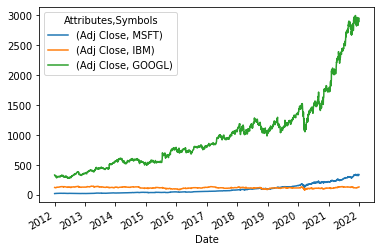

In [10]:
cols = stk_data.columns[0:3]
stk_data[cols].plot();

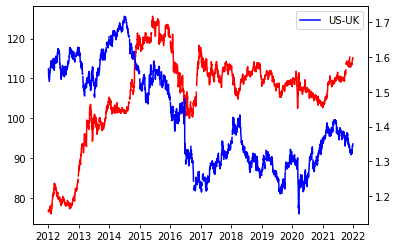

In [11]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ccy_data["JPYUSD"], color='r', label="JP-US")
ax2.plot(ccy_data["GBPUSD"], color='b', label="US-UK")
plt.legend();

We can easily show the equity index data.

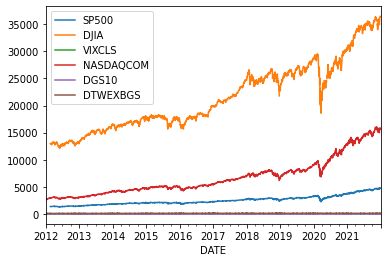

In [12]:
idx_data.plot();

### Prediction

Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

We now define our Y series and our X series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns
    b. IBM 5 Business DayReturns    
    c. USD/JPY 5 Business DayReturns    
    d. GBP/USD 5 Business DayReturns    
    e. S&P 500 5 Business DayReturns    
    f. Dow Jones 5 Business DayReturns    
    g. MSFT 5 Business Day Returns    
    h. MSFT 15 Business Day Returns    
    i. MSFT 30 Business Day Returns    
    j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [13]:
msft_close = stk_data[('Adj Close', 'MSFT')]

In [14]:
msft_close

Date
2012-01-03     21.623131
2012-01-04     22.132008
2012-01-05     22.358171
2012-01-06     22.705511
2012-01-09     22.406641
                 ...    
2021-12-27    341.743378
2021-12-28    340.545837
2021-12-29    341.244415
2021-12-30    338.619843
2021-12-31    335.626038
Name: (Adj Close, MSFT), Length: 2517, dtype: float64

We first take logs.

In [15]:
np.log(msft_close).tail(10) #.shift(-return_period)

Date
2021-12-17    5.778060
2021-12-20    5.765974
2021-12-21    5.788781
2021-12-22    5.806677
2021-12-23    5.811139
2021-12-27    5.834060
2021-12-28    5.830550
2021-12-29    5.832599
2021-12-30    5.824878
2021-12-31    5.815998
Name: (Adj Close, MSFT), dtype: float64

We then take differences

In [16]:
return_period = 5
Y = np.log(msft_close).diff(return_period)
Y

Date
2012-01-03         NaN
2012-01-04         NaN
2012-01-05         NaN
2012-01-06         NaN
2012-01-09         NaN
                ...   
2021-12-27    0.056000
2021-12-28    0.064576
2021-12-29    0.043818
2021-12-30    0.018201
2021-12-31    0.004858
Name: (Adj Close, MSFT), Length: 2517, dtype: float64

We then shift it back 5 days.

In [17]:
Y = np.log(msft_close).diff(return_period).shift(-return_period)
Y.tail(10)

Date
2021-12-17    0.056000
2021-12-20    0.064576
2021-12-21    0.043818
2021-12-22    0.018201
2021-12-23    0.004858
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
Name: (Adj Close, MSFT), dtype: float64

In [18]:
Y.name = 'MSFT_pred'

<AxesSubplot:xlabel='Date'>

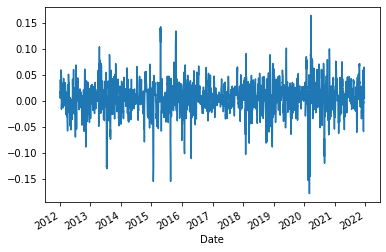

In [19]:
Y.plot()

Now we continue with the other manipulations.

In [20]:
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) \
                for i in [return_period, \
                          return_period*3, \
                          return_period*6, \
                          return_period*12]], axis=1).dropna()

X4.columns = ['MSFT_RET_DT', 'MSFT_RET_3DT', 'MSFT_RET_6DT', 'MSFT_RET_12DT']

X = pd.concat([X1, X2, X3, X4], join = "inner", axis=1)

dataset = pd.concat([Y, X], join="inner", axis=1).dropna() # .iloc[::return_period, :]

# Now extract from dataset the label column
Y = dataset.loc[:, Y.name]
# Now extract from dataset the features columns
X = dataset.loc[:, X.columns]

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [27]:
pd.describe_option()

compute.use_bottleneck : bool
    Use the bottleneck library to accelerate if it is installed,
    the default is True
    Valid values: False,True
    [default: True] [currently: True]
compute.use_numba : bool
    Use the numba engine option for select operations if it is installed,
    the default is False
    Valid values: False,True
    [default: False] [currently: False]
compute.use_numexpr : bool
    Use the numexpr library to accelerate computation if it is installed,
    the default is True
    Valid values: False,True
    [default: True] [currently: True]
display.chop_threshold : float or None
    if set to a float value, all float values smaller then the given threshold
    will be displayed as exactly 0 by repr and friends.
    [default: None] [currently: None]
display.colheader_justify : 'left'/'right'
    Controls the justification of column headers. used by DataFrameFormatter.
    [default: right] [currently: right]
display.column_space No description available.
    [defa

In [28]:
pd.set_option('display.precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,JPYUSD,GBPUSD,SP500,DJIA,VIXCLS,NASDAQCOM,DGS10,DTWEXBGS,MSFT_RET_DT,MSFT_RET_3DT,MSFT_RET_6DT,MSFT_RET_12DT
count,2290.000,2290.000,2.290e+03,2.290e+03,2.290e+03,2290.000,2290.000,2290.000,2290.000,2.290e+03,2.290e+03,2290.000,2290.000,2290.000,2290.000
mean,0.005,0.004,-2.260e-04,5.778e-04,-4.522e-04,0.002,0.002,0.001,0.003,-8.382e-04,5.327e-04,0.005,0.016,0.032,0.064
std,0.031,0.033,3.152e-02,1.227e-02,1.273e-02,0.021,0.022,0.159,0.024,6.110e-02,7.000e-03,0.032,0.049,0.065,0.083
min,-0.179,-0.168,-2.312e-01,-5.226e-02,-1.112e-01,-0.198,-0.209,-0.559,-0.193,-7.115e-01,-2.394e-02,-0.179,-0.282,-0.299,-0.165
25%,-0.011,-0.014,-1.481e-02,-5.993e-03,-7.437e-03,-0.006,-0.007,-0.090,-0.008,-3.075e-02,-3.708e-03,-0.011,-0.010,-0.006,0.012
50%,0.007,0.006,1.087e-03,6.789e-04,-5.242e-04,0.004,0.003,-0.010,0.005,-3.472e-03,4.463e-04,0.006,0.018,0.033,0.072
75%,0.023,0.023,1.655e-02,7.335e-03,7.246e-03,0.013,0.012,0.078,0.017,3.010e-02,4.517e-03,0.023,0.044,0.072,0.118
max,0.164,0.230,1.753e-01,6.909e-02,7.540e-02,0.160,0.183,1.141,0.125,3.640e-01,4.878e-02,0.164,0.245,0.285,0.377


In [29]:
dataset.head()

,MSFT_pred,GOOGL,IBM,JPYUSD,GBPUSD,SP500,DJIA,VIXCLS,NASDAQCOM,DGS10,DTWEXBGS,MSFT_RET_DT,MSFT_RET_3DT,MSFT_RET_6DT,MSFT_RET_12DT
2012-03-29,-0.019,0.004,0.013,-2.670e-03,6.558e-03,7.511e-03,7.612e-03,-0.006,1.040e-02,-0.049,-1.036e-03,0.004,0.003,0.067,0.189
2012-03-30,-0.037,-0.002,0.015,7.283e-04,7.598e-03,8.098e-03,9.988e-03,0.045,7.679e-03,-0.009,-1.726e-03,0.008,0.008,0.031,0.170
2012-04-02,-0.058,-0.004,0.008,-8.242e-03,5.194e-03,1.784e-03,1.725e-03,0.092,-9.195e-04,-0.018,-8.816e-04,-0.009,0.008,0.033,0.161
2012-04-03,-0.051,-0.007,0.011,-1.173e-02,-3.757e-04,6.087e-04,1.379e-04,0.004,-2.175e-03,0.044,-9.697e-04,-0.018,-0.023,0.016,0.134
2012-04-04,-0.007,-0.032,-0.006,-1.451e-03,1.513e-03,-4.692e-03,-3.928e-03,0.061,-1.195e-02,0.018,2.485e-03,-0.031,-0.049,-0.002,0.124


<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period

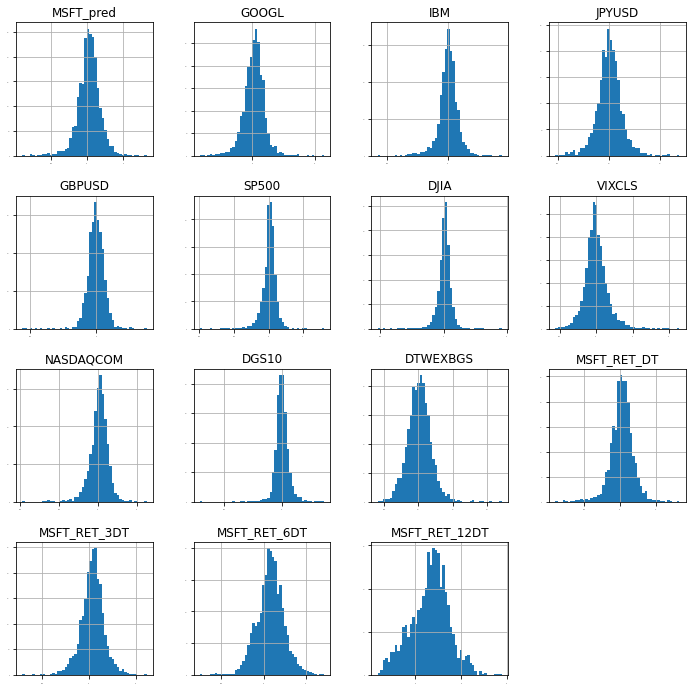

In [30]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

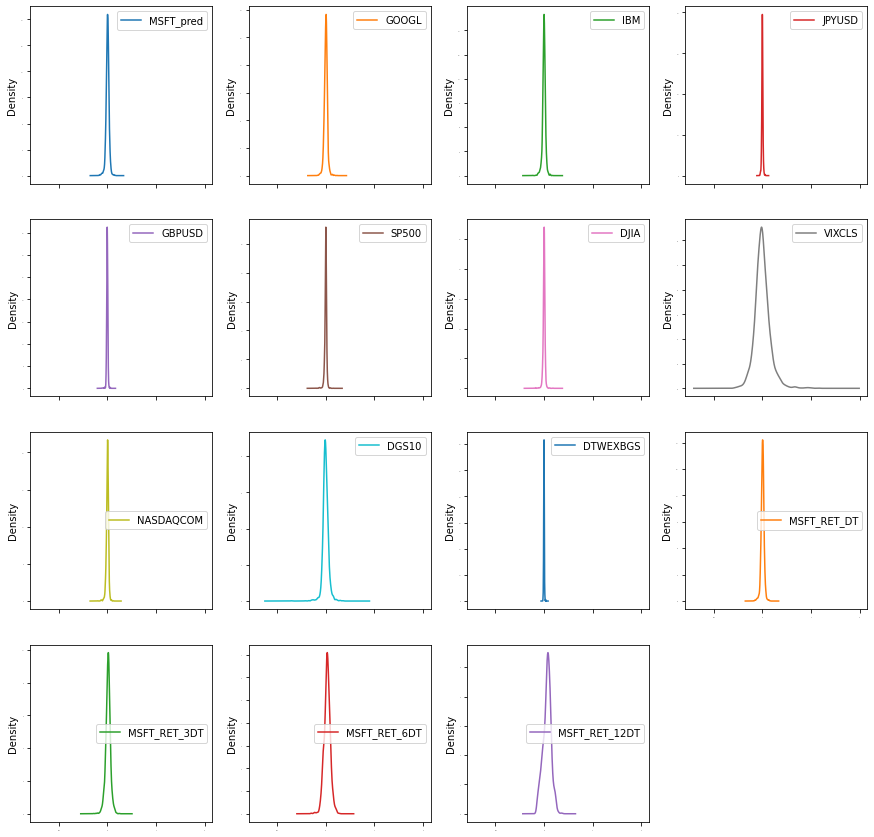

In [32]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

We can see that the vix has a much larger variance compared to the other distributions.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

<AxesSubplot:title={'center':'Correlation Matrix'}>

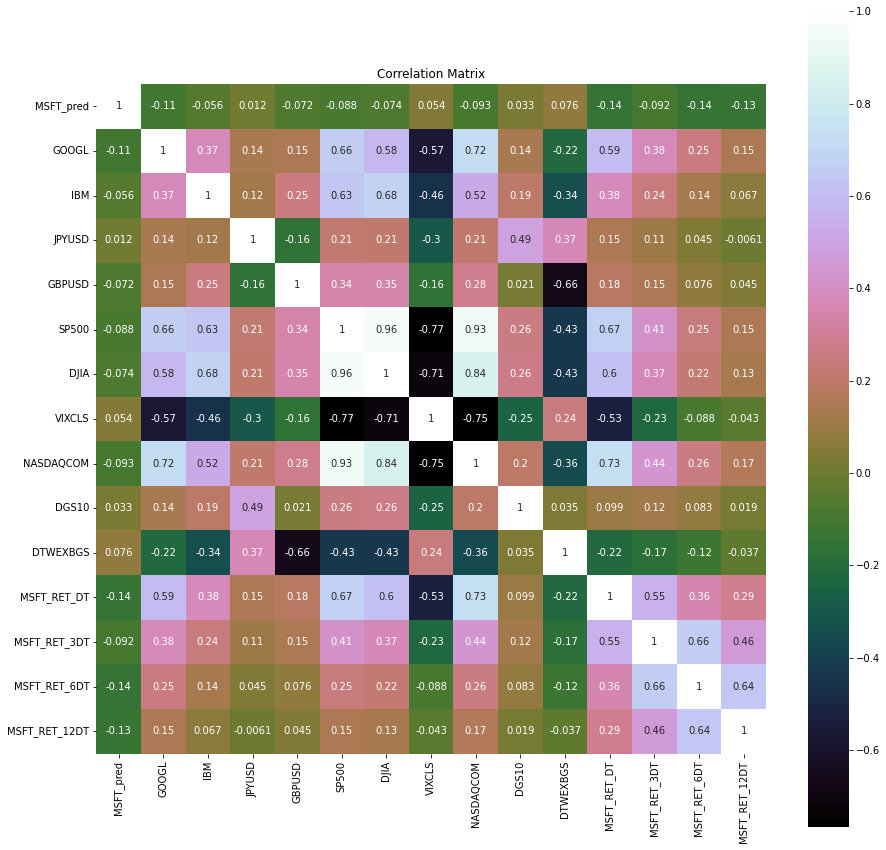

In [33]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Looking at the correlation plot above, we see some correlation of the predicted vari‐
able with the lagged 5 days, 15days, 30 days and 60 days return of MSFT. 

<Figure size 1080x1080 with 0 Axes>

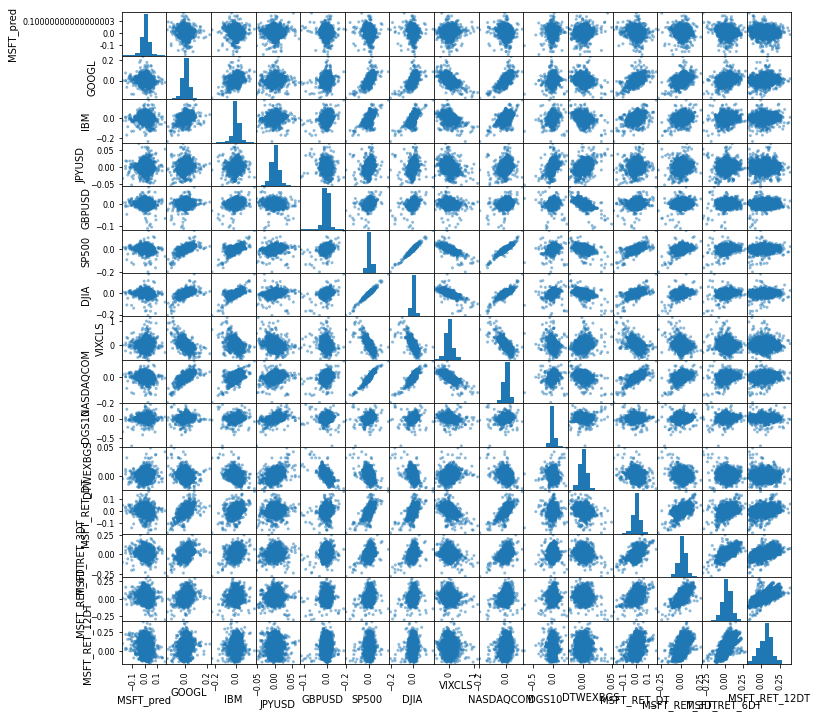

In [34]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show();

Looking at the scatter plot above, we see some linear relationship of the predicted
variable the lagged 15 days, 30 days and 60 days return of MSFT.

<a id='3'></a>
# 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection

We use sklearn's SelectKBest function to get a sense of feature importance. 

In [35]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)

In [36]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(15,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_RET_6DT,48.284
MSFT_RET_DT,44.724
MSFT_RET_12DT,41.146
GOOGL,26.484
NASDAQCOM,20.149
MSFT_RET_3DT,19.631
SP500,18.029
DTWEXBGS,13.237
DJIA,12.541


We see that MSF_RET_DT seems to be the most important feature and VIX and JPYUSD being the least important.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

In [37]:
validation_size = 0.2

# In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [39]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

##### Regression and Tree Regression algorithms

In [40]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(100,100))))
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset.

In [42]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K-Fold analysis:
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000854 (0.000348) 0.000810 0.001602
LASSO: 0.000861 (0.000366) 0.000859 0.001519
KNN: 0.001067 (0.000386) 0.000501 0.001654
CART: 0.001793 (0.000382) 0.000000 0.003009
SVR: 0.001646 (0.000243) 0.001532 0.002285
MLP: 0.000873 (0.000352) 0.000804 0.001624
ABR: 0.000977 (0.000312) 0.000771 0.001758
RFR: 0.000904 (0.000339) 0.000101 0.001623


#### K Fold results

We being by looking at the K Fold results

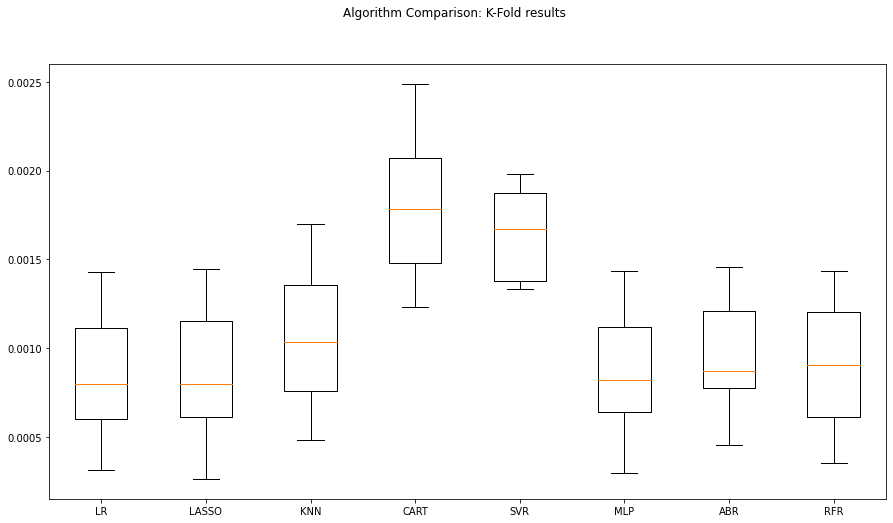

In [43]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: K-Fold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.

#### Training and Test error

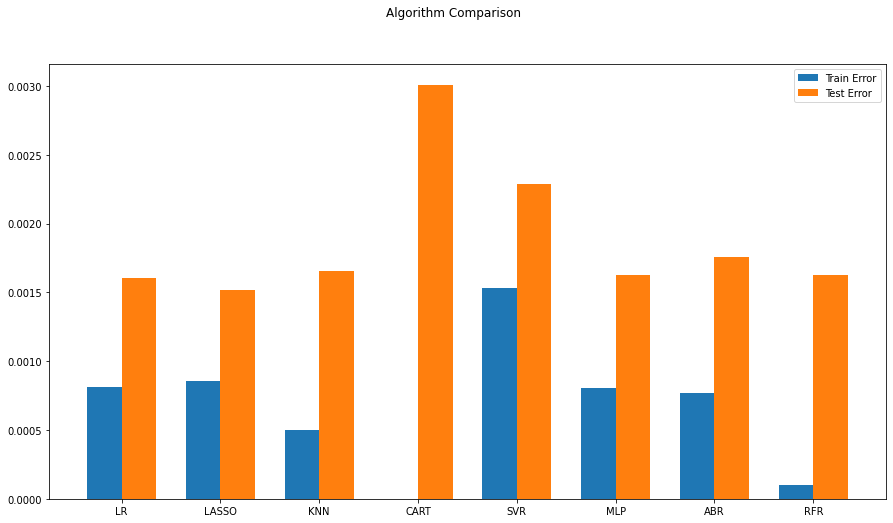

In [44]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on
the training data and produced very high error on the test set and these models
should be avoided. Ensemble models, such as gradient boosting regression (GBR) and
random forest regression (RFR) have low bias but high variance. 

Looking at the chart above, we supervised-regression models such as Linear Regression (LR) and Lasso Regression (LASSO) did OK. 

# 6. Model Tuning and Grid Search

We won't do this now.

<a id='6'></a>
# 7. Finalise the Model

### Summary

We can conclude that simple models - linear regression, regularized regression (i.e. Lasso and elastic net) - along with the time series model such as ARIMA are promising modelling approaches for asset price prediction problem. These models can enable financial practitioners to model time dependencies with a very flexible approach. The overall approach presented in this case study may help us encounter overfitting and underfitting which are some of the key challenges in the prediction problem in finance.

We should also note that we can use better set of indicators, such as P/E ratio, trading volume, technical indicators or news data, which might lead to better results. We will demonstrate this in some of the case studies in the book.

Overall, we created a supervised-regression and time series modelling framework which allows us to perform asset class prediction using historical data to generate results and analyze risk and profitability before risking any actual capital.